# Librerias necesarias y dataFrame

In [293]:
import pandas as pd
import numpy as np
import unicodedata
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

data = {
    'Texto': [
        "Aprendi regresiones", "El profe no da mas tiempo en las tareas",
        "Las office hours son en un horario muy maluco y no el profe no contesta los correos",
        "Tareas muy largas y toca dedicar mucho tiempo", "Aprendi a utilizar imágenes",
        "El profe se demora en entregar las notas", "La tarea de clasificar las plantas me gusto",
        "Los examenes son dificiles y largos", "Me gusta cuando el profe resuelve los problemas en excel",
        "Utilizar texto es util y aprender NLP", "Las redes neuronales me parecen poderosas y me gusto la parte practica",
        "Falto aprender mas spark", "Las office hours son los sabados y no me gusta madrugar",
        "Aprendi python y pandas", "Me gusto trabajar con datos reales", "Aprendi que es un cluster",
        "Las tareas son practicas con datos reales", "las derivadas son muy utiles y me gusto la matematica",
        "Pandas es com un excel y me gusto", "es aburrido el tema y me distraigo en la parte teorica",
        "Es dificl y me toco cancelar la materia"
    ],
    'Sentimiento': [
        'Positivo', 'Negativo', 'Negativo', 'Negativo', 'Positivo', 'Negativo', 'Positivo', 'Negativo',
        'Positivo', 'Positivo', 'Positivo', 'Negativo', 'Negativo', 'Positivo', 'Positivo', 'Positivo',
        'Positivo', 'Positivo', 'Positivo', 'Negativo', 'Negativo'
    ]
}

df = pd.DataFrame(data)

# Procesar el texto antes de usarlo

In [294]:
nltk.download('stopwords')
tokenizer = ToktokTokenizer()
stopwords_spanish = set(stopwords.words('spanish'))

def eliminarAcentos(texto):
    return ''.join(c for c in unicodedata.normalize('NFKD', texto) if not unicodedata.combining(c))

def preprocesarTexto(texto):
    texto = eliminarAcentos(texto)
    texto = texto.lower()
    texto = re.sub(r'\W+', ' ', texto)
    return texto

df['Texto'] = df['Texto'].apply(preprocesarTexto)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funciones para frecuencia de palabras

In [295]:
def contarPalabras(textos):
    diccionarioPalabras = defaultdict(int)
    for texto in textos:
        palabras = tokenizer.tokenize(texto)
        palabras = [palabra.strip() for palabra in palabras if palabra not in stopwords_spanish]
        for palabra in palabras:
            diccionarioPalabras[palabra] += 1
    return diccionarioPalabras

frecuenciaPalabras = contarPalabras(df['Texto'])
palabrasOrdenadas = sorted(frecuenciaPalabras.items(), key=lambda x: x[1], reverse=True)

# Gráfico de las palabras más usadas

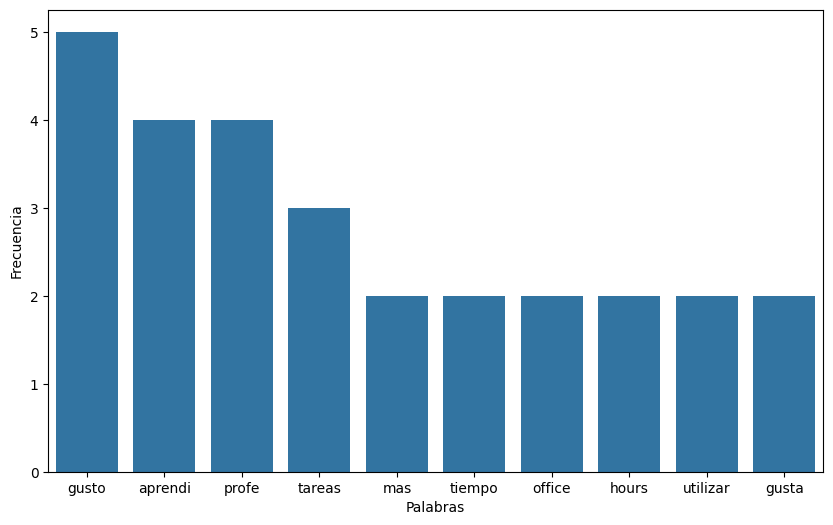

In [296]:
top10Palabras = palabrasOrdenadas[:10]
palabras, frecuencias = zip(*top10Palabras)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(palabras), y=list(frecuencias))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

# Correlación con el Sentimiento, matriz TF-IDF


In [297]:
vectorizer = TfidfVectorizer(stop_words=list(stopwords_spanish))
tfidfMatrix = vectorizer.fit_transform(df['Texto'])
tfidfDf = pd.DataFrame(tfidfMatrix.toarray(), columns=vectorizer.get_feature_names_out())

# Sentimiento en el df y correlación

In [298]:
df['Sentimiento'] = df['Sentimiento'].map({'Positivo': 1, 'Negativo': 0})

correlacion = tfidfDf.corrwith(df['Sentimiento'])
correlacionOrdenada = correlacion.sort_values(ascending=False)

print("Tabla completa de correlación con el sentimiento:")
print(correlacionOrdenada)

Tabla completa de correlación con el sentimiento:
gusto      0.479342
aprendi    0.417412
reales     0.280944
datos      0.280944
pandas     0.280300
             ...   
profe     -0.309545
hours     -0.373146
office    -0.373146
tiempo    -0.374259
mas       -0.374607
Length: 65, dtype: float64


# Ordenar la Matriz TF-IDF por el numero de uso de las palabras

In [299]:
palabrasOrdenadasFrecuencia = [palabra for palabra, frecuencia in palabrasOrdenadas]
tfidfDfOrdenada = tfidfDf[palabrasOrdenadasFrecuencia]

print("Matriz TF-IDF ordenada:")
print(tfidfDfOrdenada.head())

Matriz TF-IDF ordenada:
   gusto   aprendi     profe    tareas       mas    tiempo    office  \
0    0.0  0.589788  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.0  0.000000  0.378754  0.412811  0.456719  0.456719  0.000000   
2    0.0  0.000000  0.296079  0.000000  0.000000  0.000000  0.357026   
3    0.0  0.000000  0.000000  0.379085  0.000000  0.419405  0.000000   
4    0.0  0.480633  0.000000  0.000000  0.000000  0.000000  0.000000   

      hours  utilizar  gusta  ...  matematica  com  aburrido  tema  distraigo  \
0  0.000000  0.000000    0.0  ...         0.0  0.0       0.0   0.0        0.0   
1  0.000000  0.000000    0.0  ...         0.0  0.0       0.0   0.0        0.0   
2  0.357026  0.000000    0.0  ...         0.0  0.0       0.0   0.0        0.0   
3  0.000000  0.000000    0.0  ...         0.0  0.0       0.0   0.0        0.0   
4  0.000000  0.579568    0.0  ...         0.0  0.0       0.0   0.0        0.0   

   teorica  dificl  toco  cancelar  materia  
0      0.0

# Inicializar los parámetros y funciones necesarias


In [300]:
m, n = tfidfDf.shape
W = np.zeros(n)
b = 0
learningRate = 0.5
epochs = 6
batchSize = 3

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logLoss(y_true, y_pred):
    return - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

coeficientes = []

# Implementar el gradiente descendiente

In [301]:
for epoch in range(epochs):
    for i in range(0, m, batchSize):
        X_batch = tfidfDf.iloc[i:i+batchSize]
        y_batch = df['Sentimiento'].iloc[i:i+batchSize]

        z = np.dot(X_batch, W) + b
        y_pred = sigmoid(z)

        loss = logLoss(y_batch, y_pred)

        dw = (1 / batchSize) * np.dot(X_batch.T, (y_pred - y_batch))
        db = (1 / batchSize) * np.sum(y_pred - y_batch)

        W -= learningRate * dw
        b -= learningRate * db

        if i == 0:
            coeficientes.append([epoch + 1] + list(W[:4]))

columnas = ['Iteracion', 'b1', 'b2', 'b3', 'b4']
tabla_coeficientes = pd.DataFrame(coeficientes, columns=columnas)

print("Tabla de coeficientes:")
print(tabla_coeficientes)

Tabla de coeficientes:
   Iteracion        b1        b2        b3        b4
0          1  0.000000  0.000000  0.049149  0.000000
1          2 -0.044872 -0.002675  0.213427 -0.048785
2          3 -0.089446 -0.010457  0.354937 -0.097038
3          4 -0.132603 -0.019510  0.482920 -0.143553
4          5 -0.174003 -0.028535  0.601069 -0.187975
5          6 -0.213584 -0.037124  0.711116 -0.230256


# Predicción y evaluación del modeli

In [302]:
z_test = np.dot(tfidfDf, W) + b
y_pred_test = sigmoid(z_test)
predicciones = [1 if i > 0.5 else 0 for i in y_pred_test]
accuracy = accuracy_score(df['Sentimiento'], predicciones)
print(f"Accuracy: {accuracy}")

df['Predicción'] = predicciones

resultado = df[['Texto', 'Sentimiento', 'Predicción']]
print("Resultados de la clasificación:")
print(resultado)

Accuracy: 1.0
Resultados de la clasificación:
                                                Texto  Sentimiento  Predicción
0                                 aprendi regresiones            1           1
1             el profe no da mas tiempo en las tareas            0           0
2   las office hours son en un horario muy maluco ...            0           0
3       tareas muy largas y toca dedicar mucho tiempo            0           0
4                         aprendi a utilizar imagenes            1           1
5            el profe se demora en entregar las notas            0           0
6         la tarea de clasificar las plantas me gusto            1           1
7                 los examenes son dificiles y largos            0           0
8   me gusta cuando el profe resuelve los problema...            1           1
9               utilizar texto es util y aprender nlp            1           1
10  las redes neuronales me parecen poderosas y me...            1           1
11    

# Declaración del modelo mV1_0
#   
# Calculos de -> f1, precision, recall y matriz de confusion

In [303]:
def mV1_0_model(texto, palabraClave="aprendi"):
    palabras = texto.split()
    numPalabras = len(palabras)
    if palabraClave in palabras:
        numPalabraClave = palabras.count(palabraClave)
        pPositivo = 0.5 + (numPalabraClave / numPalabras) * 0.5
    else:
        pPositivo = 0 + min(1, max(1 - (numPalabras / 12), 0)) * 0.5
    return 1 if pPositivo > 0.5 else 0

df['Predicción_mV1_0'] = df['Texto'].apply(mV1_0_model)

y_true = df['Sentimiento']
y_pred_mV1_0 = df['Predicción_mV1_0']
y_pred_mV2_0 = df['Predicción']

print("Modelo mV1_0:")
print(f"F1 Score: {f1_score(y_true, y_pred_mV1_0)}")
print(f"Precision: {precision_score(y_true, y_pred_mV1_0)}")
print(f"Recall: {recall_score(y_true, y_pred_mV1_0)}")
print("Matriz de Confusión:\n", confusion_matrix(y_true, y_pred_mV1_0))

print("\nModelo mV2_0:")
print(f"F1 Score: {f1_score(y_true, y_pred_mV2_0)}")
print(f"Precision: {precision_score(y_true, y_pred_mV2_0)}")
print(f"Recall: {recall_score(y_true, y_pred_mV2_0)}")
print("Matriz de Confusión:\n", confusion_matrix(y_true, y_pred_mV2_0))

Modelo mV1_0:
F1 Score: 0.5
Precision: 1.0
Recall: 0.3333333333333333
Matriz de Confusión:
 [[9 0]
 [8 4]]

Modelo mV2_0:
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
Matriz de Confusión:
 [[ 9  0]
 [ 0 12]]


# Creación del GainChart

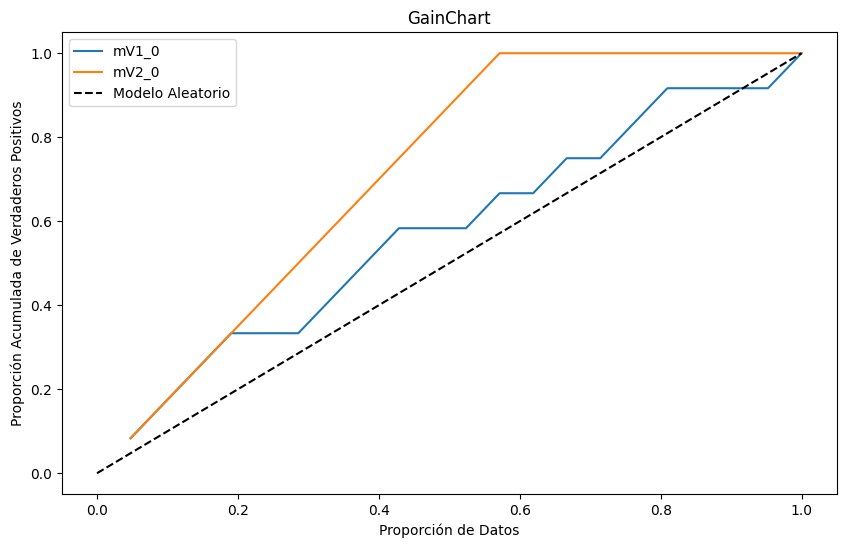

In [304]:
def gainChart(y_true, y_scores, model_name):
    sortedIndices = np.argsort(y_scores)[::-1]
    sortedTrueLabels = np.array(y_true)[sortedIndices]
    acumulado = np.cumsum(sortedTrueLabels) / np.sum(sortedTrueLabels)
    total = np.arange(1, len(y_true) + 1) / len(y_true)
    plt.plot(total, acumulado, label=model_name)

p_positivo_mV1_0 = df['Texto'].apply(lambda texto: 0.5 + (texto.split().count("aprendi") / len(texto.split())) * 0.5 if "aprendi" in texto.split() else 0 + min(1, max(1 - (len(texto.split()) / 12), 0)) * 0.5)
p_positivo_mV2_0 = sigmoid(np.dot(tfidfDf, W) + b)

plt.figure(figsize=(10, 6))
gainChart(y_true, p_positivo_mV1_0, "mV1_0")
gainChart(y_true, p_positivo_mV2_0, "mV2_0")
plt.plot([0, 1], [0, 1], 'k--', label="Modelo Aleatorio")
plt.title('GainChart')
plt.xlabel('Proporción de Datos')
plt.ylabel('Proporción Acumulada de Verdaderos Positivos')
plt.legend()
plt.show()

# Modelo en python utilizando las librerías

In [305]:
logistic_model = LogisticRegression()
logistic_model.fit(tfidfDf, df['Sentimiento'])

LogisticRegression()

# Tabla de coeficientes

In [306]:
coeficientes = pd.DataFrame({
    'Palabra': vectorizer.get_feature_names_out(),
    'Coeficiente': logistic_model.coef_[0]
})

coeficientes = coeficientes.reindex(coeficientes.Coeficiente.abs().sort_values(ascending=False).index)
print("Tabla de coeficientes:")
print(coeficientes.head(10))

Tabla de coeficientes:
     Palabra  Coeficiente
2    aprendi     0.648478
22     gusto     0.561470
30       mas    -0.389881
58    tiempo    -0.363425
36    office    -0.330996
24     hours    -0.330996
47    reales     0.325235
10     datos     0.325235
37    pandas     0.322050
64  utilizar     0.321128


# Grafico de coeficinetes

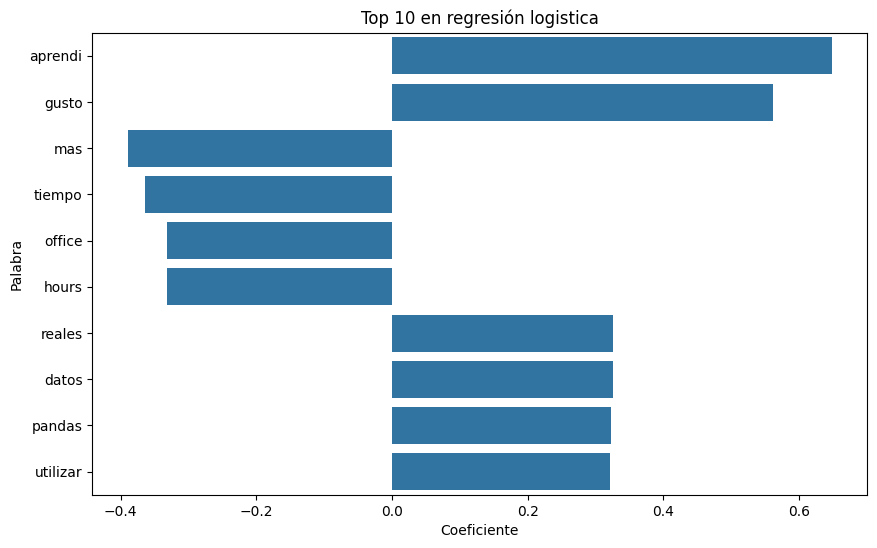

In [307]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Palabra', data=coeficientes.head(10))
plt.title('Top 10 en regresión logistica')
plt.show()